<a href="https://colab.research.google.com/github/HenningBuhl/VQ-VAE_Keras_Implementation/blob/master/VQ_VAE_Keras_MNIST_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQ-VAE Keras MNIST Example

In [1]:
# Imports.
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import keras

from keras.models import Model
from keras.layers import Input, Layer, Activation, Dense, Flatten, Dropout, Lambda, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, SpatialDropout2D
from keras.layers.normalization import BatchNormalization
from keras import losses
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import mnist, fashion_mnist

Using TensorFlow backend.


In [0]:
# Load data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data.
x_test = x_test / np.max(x_train)
x_train = x_train / np.max(x_train)

# Add input channel dimension.
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to categorical.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Target dictionary.
target_dict = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [0]:
# VQ layer.
class VQVAELayer(Layer):
    def __init__(self, embedding_dim, num_embeddings, commitment_cost,
                 initializer='uniform', epsilon=1e-10, **kwargs):
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.initializer = initializer
        super(VQVAELayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Add embedding weights.
        self.w = self.add_weight(name='embedding',
                                  shape=(self.embedding_dim, self.num_embeddings),
                                  initializer=self.initializer,
                                  trainable=True)

        # Finalize building.
        super(VQVAELayer, self).build(input_shape)

    def call(self, x):
        # Flatten input except for last dimension.
        flat_inputs = K.reshape(x, (-1, self.embedding_dim))

        # Calculate distances of input to embedding vectors.
        distances = (K.sum(flat_inputs**2, axis=1, keepdims=True)
                     - 2 * K.dot(flat_inputs, self.w)
                     + K.sum(self.w ** 2, axis=0, keepdims=True))

        # Retrieve encoding indices.
        encoding_indices = K.argmax(-distances, axis=1)
        encodings = K.one_hot(encoding_indices, self.num_embeddings)
        encoding_indices = K.reshape(encoding_indices, K.shape(x)[:-1]) # Use Tuple for shape? (dim,)
        quantized = self.quantize(encoding_indices)

        # Metrics.
        #avg_probs = K.mean(encodings, axis=0)
        #perplexity = K.exp(- K.sum(avg_probs * K.log(avg_probs + epsilon)))
        
        return quantized

    @property
    def embeddings(self):
        return self.w

    def quantize(self, encoding_indices):
        w = K.transpose(self.embeddings.read_value())
        return tf.nn.embedding_lookup(w, encoding_indices, validate_indices=False)

In [0]:
# Calculate vq-vae loss.
def vq_vae_loss_wrapper(data_variance, commitment_cost, quantized, x_inputs):
    def vq_vae_loss(x, x_hat):
        recon_loss = losses.mse(x, x_hat) / data_variance
        
        e_latent_loss = K.mean((K.stop_gradient(quantized) - x_inputs) ** 2)
        q_latent_loss = K.mean((quantized - K.stop_gradient(x_inputs)) ** 2)
        loss = q_latent_loss + commitment_cost * e_latent_loss
        
        return recon_loss + loss #* beta
    return vq_vae_loss

In [0]:
# Hyper Parameters.
epochs = 1000 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 32 # Length of embedding vectors.
num_embeddings = 128 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [6]:
# Encoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu')(input_img)
#x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Dropout(0.3)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.4)(x)

# VQVAELayer.
enc = Conv2D(embedding_dim, kernel_size=(1, 1), strides=(1, 1), name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv2DTranspose(64, (3, 3), activation='relu')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
x = Conv2DTranspose(1, (3, 3))(x)

# Autoencoder.
vqvae = Model(input_img, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

W0817 17:13:35.471924 139936472061824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 17:13:35.491487 139936472061824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 17:13:35.497127 139936472061824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0817 17:13:35.530254 139936472061824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0817 17:13:36.093877 139936472061824 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)          36928     
__________

In [7]:
history = vqvae.fit(x_train, x_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

W0817 17:13:36.546561 139936472061824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0817 17:13:36.715598 139936472061824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0817 17:13:37.009827 139936472061824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 54000 samples, validate on 6000 samples
Epoch 1/1000
54000/54000 [==============================] - 20s 372us/step - loss: 8.7738 - val_loss: 3.0240
Epoch 2/1000
54000/54000 [==============================] - 17s 315us/step - loss: 2.1069 - val_loss: 1.5640
Epoch 3/1000
54000/54000 [==============================] - 17s 315us/step - loss: 1.2748 - val_loss: 1.1232
Epoch 4/1000
54000/54000 [==============================] - 17s 316us/step - loss: 1.0077 - val_loss: 0.9147
Epoch 5/1000
54000/54000 [==============================] - 17s 315us/step - loss: 0.8704 - val_loss: 0.8238
Epoch 6/1000
54000/54000 [==============================] - 17s 313us/step - loss: 0.8059 - val_loss: 0.8037
Epoch 7/1000
54000/54000 [==============================] - 17s 314us/step - loss: 0.7650 - val_loss: 0.7345
Epoch 8/1000
54000/54000 [==============================] - 17s 315us/step - loss: 0.7332 - val_loss: 0.6929
Epoch 9/1000
54000/54000 [==============================] - 17s 316us/step - lo

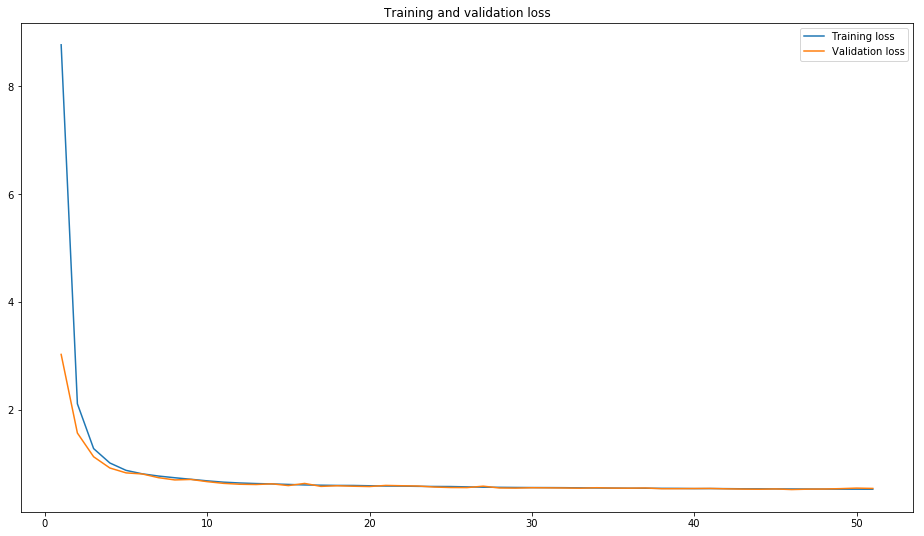

In [8]:
# Plot training results.
loss = history.history['loss'] # Training loss.
val_loss = history.history['val_loss'] # Validation loss.
num_epochs = range(1, 1 + len(history.history['loss'])) # Number of training epochs.

plt.figure(figsize=(16,9))
plt.plot(num_epochs, loss, label='Training loss') # Plot training loss.
plt.plot(num_epochs, val_loss, label='Validation loss') # Plot validation loss.

plt.title('Training and validation loss')
plt.legend(loc='best')
plt.show()

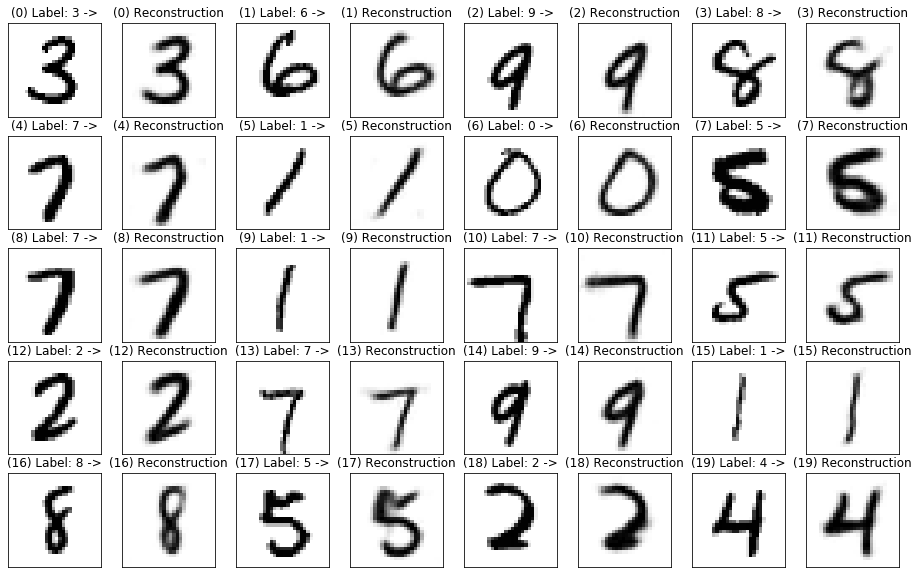

In [9]:
# Show original reconstruction.
n_rows = 5
n_cols = 8 # Must be divisible by 2.
samples_per_col = int(n_cols / 2)
sample_offset = np.random.randint(0, len(x_test) - n_rows - n_cols - 1)
#sample_offset = 0

img_idx = 0
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(1, n_rows + 1):
    for j in range(1, n_cols + 1, 2):
        idx = n_cols * (i - 1) + j

        # Display original.
        ax = plt.subplot(n_rows, n_cols, idx)
        ax.title.set_text('({:d}) Label: {:s} ->'.format(
            img_idx,
            str(target_dict[np.argmax(y_test[img_idx + sample_offset])])))
        ax.imshow(x_test[img_idx + sample_offset].reshape(28, 28),
                  cmap='gray_r',
                  clim=(0, 1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction.
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        ax.title.set_text('({:d}) Reconstruction'.format(img_idx))
        ax.imshow(vqvae.predict(
            x_test[img_idx + sample_offset].reshape(-1, 28, 28, 1)).reshape(28, 28),
            cmap='gray_r',
            clim=(0, 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        img_idx += 1
plt.show()